# Data Mining Project By :  Iheb Benali

## Title

##### Drug Review

## Description

###### Data Set Characteristics:  Multivariate, Text
###### Number of Instances: 215063
###### Area: Life
###### Attribute Characteristics: Integer
###### Number of Attributes: 6
###### Date Donated 2018-10-04
###### Number of Web Hits: 100947

## Presentation

##### The dataset provides patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction. 
##### The data was obtained by crawling online pharmaceutical review sites.

## Objectives

###### (1) sentiment analysis of drug experience over multiple facets, i.e. sentiments learned on specific aspects such as effectiveness and side effects.
###### (2) the transferability of models among domains, i.e. conditions.
###### (3) the transferability of models among different data sources .

## classification

The data is split into a train (75%) a test (25%) partition (see publication) and stored in two .tsv (tab-separated-values) files, respectively.

## Table of content

#### 1. Exploration Data Analysis
#### 1.1. Data understanding
#### 1.2. Missing value
#### 2. Date Preprocessing
#### 2.1. Missing Values Removal
#### 2.2 Condition Preprocessing
#### 2.3 Review Preprocessing
#### 3. Model
#### 3.1. Deep Learning Model Using N-gram

## Packages 

###### Pandas helps you manipulate and analyze large sets of data without having to learn a specialized data-processing language
###### NumPy provides tools to help build multi-dimensional arrays and perform calculations on the data stored in them. You can solve algebraic formulas, perform common statistical operations, and much more. like it provides part of the foundation for libraries like TensorFlow.
###### Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy.
###### Seaborn provides high-level commands to create a variety of plot types useful for statistical data exploration, and even some statistical model fitting
###### Light GBM can handle the large size of data and takes lower memory to run. Another reason of why Light GBM is popular is because it focuses on accuracy of results


## The code

In [17]:
pip install lightgbm

In [18]:
pip install plotly

In [19]:
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc

import os
import string
color = sns.color_palette()
%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

FileNotFoundError: Could not find module 'C:\Users\Omar\anaconda32\lib\site-packages\lightgbm\lib_lightgbm.dll' (or one of its dependencies). Try using the full path with constructor syntax.

In [3]:
df_train = pd.read_table("drugsComTrain_raw.tsv", parse_dates=["date"])
df_test = pd.read_table("data.tsv", parse_dates=["date"])

In [4]:
print("Train shape :" ,df_train.shape)
print("Test shape :", df_test.shape)

Train shape : (161297, 7)
Test shape : (53766, 7)


In [5]:
df_train.columns = ['uniqueID', 'drugName', 'condition','review','rating','date','useflCount']
df_test.columns = ['uniqueID', 'drugName', 'condition','review','rating','date','useflCount']



###### This is the result of looking at the data through the head () command.
###### There are six 

In [6]:

df_train.head()


,uniqueID,drugName,condition,review,rating,date,useflCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,2016-11-27,37


###### These are additional explanations for variables.
###### drugName (categorical): name of drug
###### condition (categorical): name of condition
###### review (text): patient review
###### rating (numerical): 10 star patient rating
###### date (date): date of review entry
###### usefulCount (numerical): number of users who found review useful
###### The structure of the data is that a patient with a unique ID purchases a drug that meets his condition and writes
###### a review and rating for the drug he/she purchased on the date. Afterwards, if the others read that review and find
###### it helpful, they will click usefulCount, which will add 1 for the variable.

In [7]:
# first we need to understand data 
print("unique values count of train : " ,len(set(df_train['uniqueID'].values)))
print("length of train : " ,df_train.shape[0])

unique values count of train :  161297
length of train :  161297


In [8]:

df_all = pd.concat([df_train,df_test])



Text(0.5, 1.0, 'Top20 : The number of drugs per condition.')

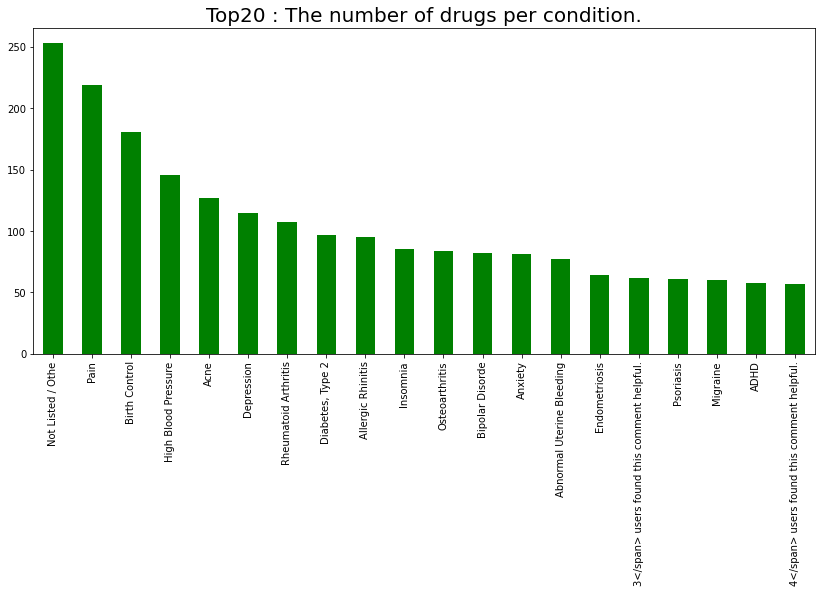

In [9]:
condition_dn = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top20 : The number of drugs per condition.", fontsize = 20)

###### As you can see from the picture above, the number of drugs for top eight conditions is about 100 for each condition.
###### On the other hand, it should be noted that the phrase "3</span> users found this comment helpful" appears in the condition,
###### which seems like an error in the crawling process. 
###### I have looked into it to see in more details.

In [10]:
df_all[df_all['condition']=='3</span> users found this comment helpful.'].head(3)


,uniqueID,drugName,condition,review,rating,date,useflCount
243,81588,Yaz,3</span> users found this comment helpful.,"""I took Yaz for a little over 2 years. From a...",3.0,2010-06-01,3
1864,124318,Skyla,3</span> users found this comment helpful.,"""Never pregnant,28,retroverted small (6cm) ute...",1.0,2015-12-16,3
3322,202848,ProAir HFA,3</span> users found this comment helpful.,"""I get chest colds and asthmatic symptoms in t...",9.0,2015-12-12,3


###### It is expected that for structure of '</ span> users found this comment helpful.' phrase, there will be not only 3, but also 4 as shown above, and other numbers as well.
###### We will remove these data in the future preprocessing.
###### The following are the low 20 conditions of 'drugs per condition'. 
###### As you can see, the number is all 1. Considering the recommendation system, it is not feasible to recommend with that when there is only one product.
###### Therefore, we will analyze only the conditions that have at least 2 drugs per condition.

Text(0.5, 1.0, 'Bottom20 : The number of drugs per condition.')

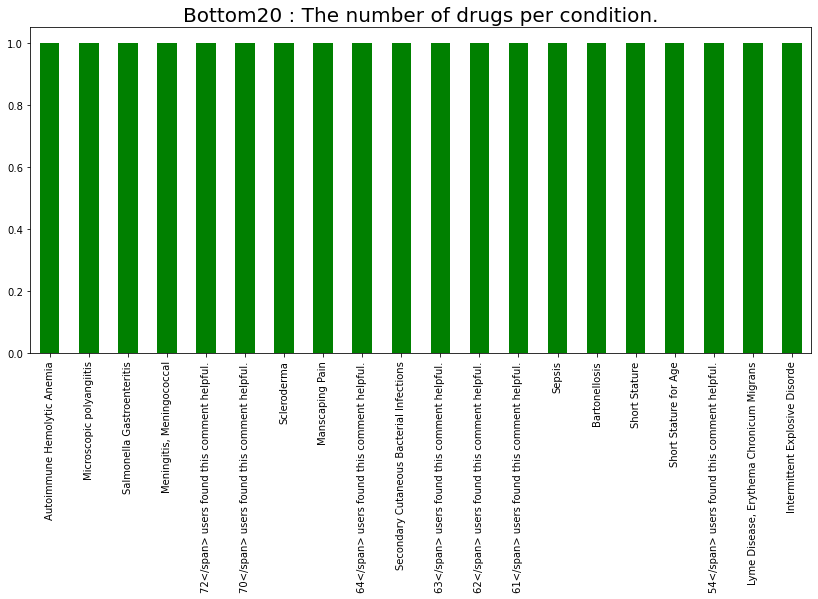

In [11]:
ondition_dn = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)

condition_dn[condition_dn.shape[0]-20:condition_dn.shape[0]].plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Bottom20 : The number of drugs per condition.", fontsize = 20)

###### Next, let's have a look at the review. First, noticeable parts are the html strings like \ r \ n, and the parts that express emotions in parentheses such as (very unusual for him) and (a good thing) and words in capital letters like MUCH.





In [12]:
df_train['review'][1]

'"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective."'

In [13]:
#In addition, there were some words with errors like didn&# 039;t for didn't, and also characters like ...
df_train['review'][2]


'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

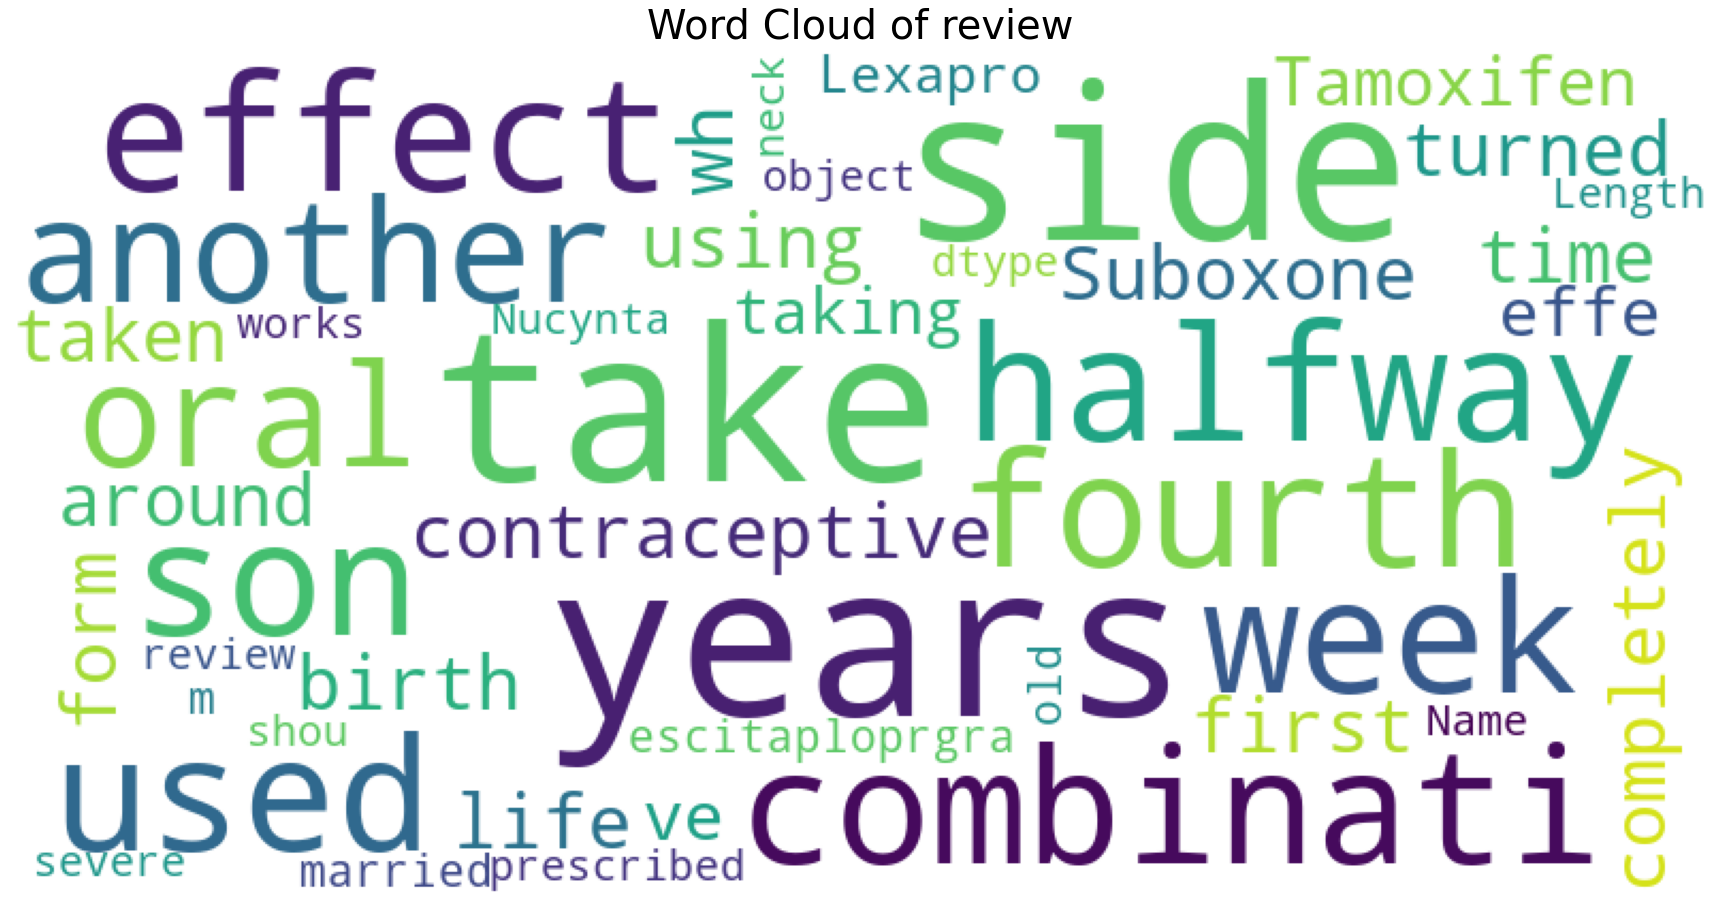

In [18]:

from wordcloud import WordCloud, STOPWORDS
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(df_all["review"], title="Word Cloud of review")

In [19]:
#Next, we will classify 1 ~ 5 as negative, and 6 ~ 10 as positive, and we will check through 1 ~ 4 grams which corpus 
#best classifies emotions.
from collections import defaultdict
df_all_6_10 = df_all[df_all["rating"]>5]
df_all_1_5 = df_all[df_all["rating"]<6]
## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from rating  8 to 10 review ##
freq_dict = defaultdict(int)
for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from rating  4 to 7 review ##
freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of rating 1 to 5", 
                                          "Frequent words of rating 6 to 10"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

D:\anaconda\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



##### When you use 1-gram, you can see that the top 5 words have the same contents, although the order of left (negative) and right (positive) are different. This means when we analyze the text with a single corpus, it does not classify the emotion well.
##### So, we will expand the corpus.

In [20]:
freq_dict = defaultdict(int)
for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent biagrams of rating 1 to 5", 
                                          "Frequent biagrams of rating 6 to 10"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1000, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

###### Likewise, in 2-gram, the contents of the top five corpus are similar, and it is hard to classify positive and negative. 
###### In addition, 'side effects' and 'side effects.' are interpreted differently, which means preprocessing of review data is necessary. However, you can see that this is better to classify emotions rather than previous 1-grams, like side effects, weight gain, and highly recommend

In [21]:
freq_dict = defaultdict(int)
for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent trigrams of rating 1 to 5", 
                                          "Frequent trigrams of rating 6 to 10"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1600, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

###### From 3-gram you can see that there is a difference between positive and negative corpus. 
###### Bad side effects, birth control pills, negative side effects are corpus that classify positive and negative.
###### However, both positive and negative parts can be thought that it has missing parts that reverses the context, such as' not' in front of a corpus


In [22]:
freq_dict = defaultdict(int)
for sent in df_all_1_5["review"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'red')

freq_dict = defaultdict(int)
for sent in df_all_6_10["review"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent 4-grams of rating 1 to 5", 
                                          "Frequent 4-grams of rating 6 to 10"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig['layout'].update(height=1200, width=1600, paper_bgcolor='rgb(233,233,233)', title="4-grams Count Plots")
py.iplot(fig, filename='word-plots')

###### Clearly, 4-gram classifies emotions much betther than other grams


Text(0.5, 1.0, 'Count of rating values')

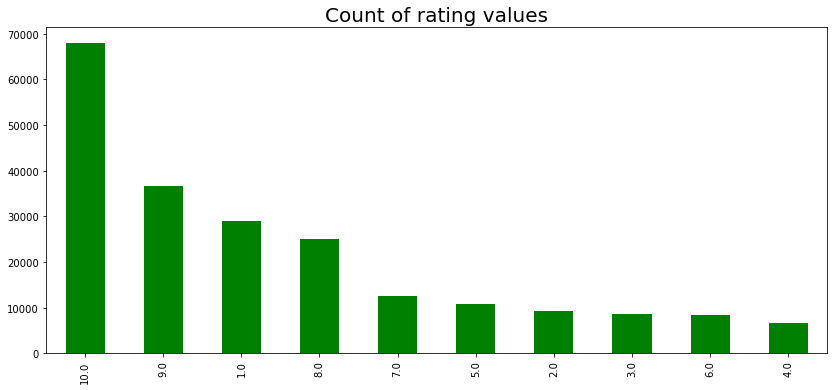

In [23]:
rating = df_all['rating'].value_counts().sort_values(ascending=False)
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Count of rating values", fontsize = 20)

###### Most people choose four values; 10, 9, 1, 8, and the number of 10 is more than twice as many as the others. With this, we can see that the percentage of positives is higher than negative, and people's reactions are extreme.


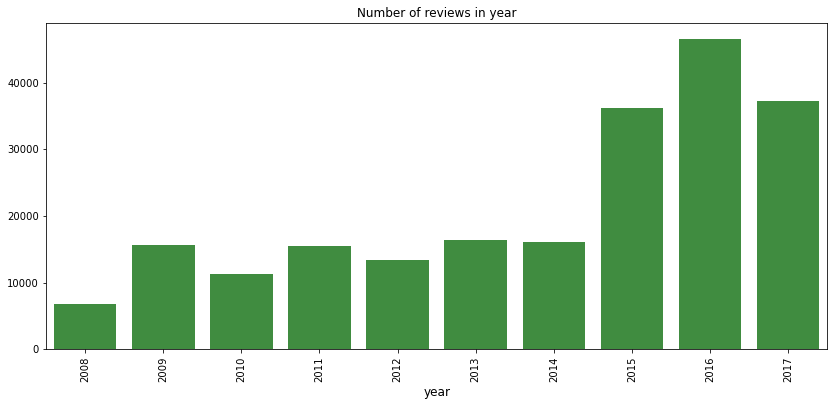

In [24]:

cnt_srs = df_all['date'].dt.year.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('year', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("Number of reviews in year")
plt.show()

Text(0.5, 1.0, 'Mean rating in year')

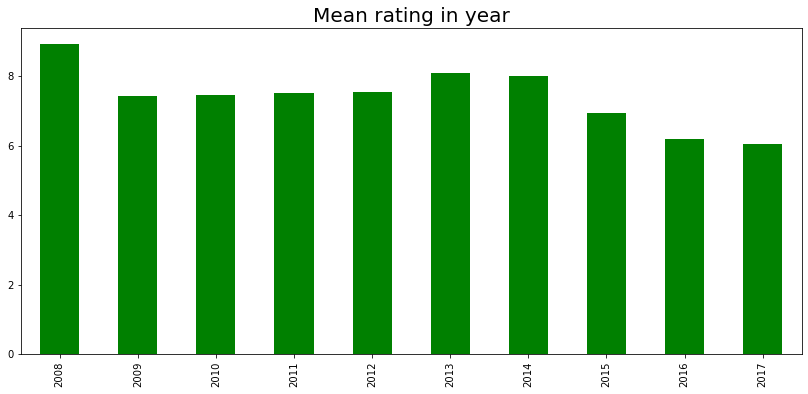

In [25]:
df_all['year'] = df_all['date'].dt.year
rating = df_all.groupby('year')['rating'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean rating in year", fontsize = 20)

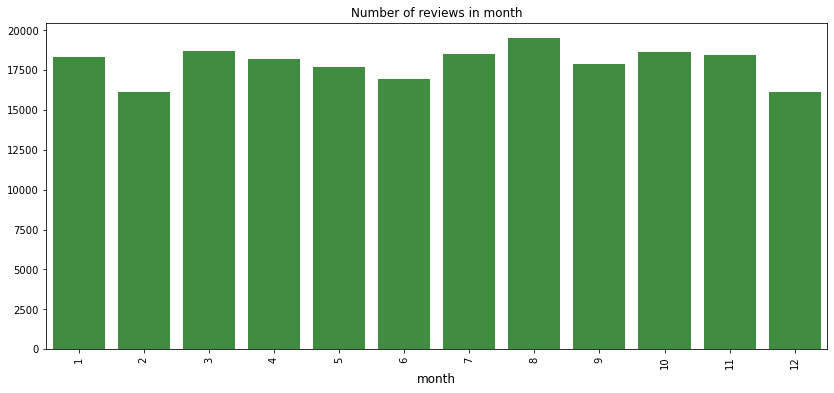

In [27]:


cnt_srs = df_all['date'].dt.month.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('month', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("Number of reviews in month")
plt.show()

##### Code in https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo
##### SRK - Simple Exploration Notebook 

Text(0.5, 1.0, 'Mean rating in month')

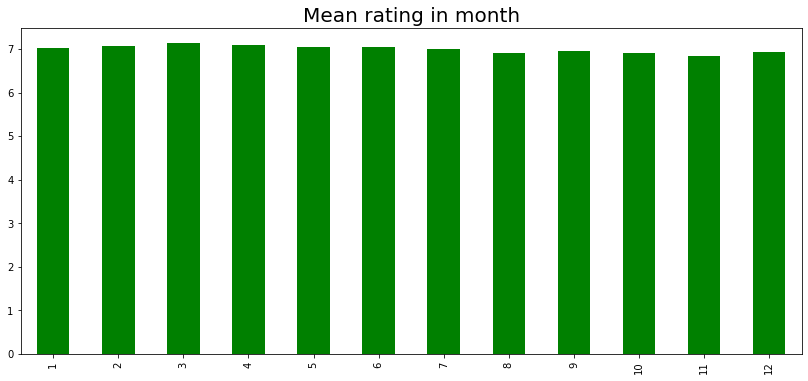

In [28]:
df_all['month'] = df_all['date'].dt.month
rating = df_all.groupby('month')['rating'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean rating in month", fontsize = 20)

Text(0.5, 1.0, 'Mean rating in day')

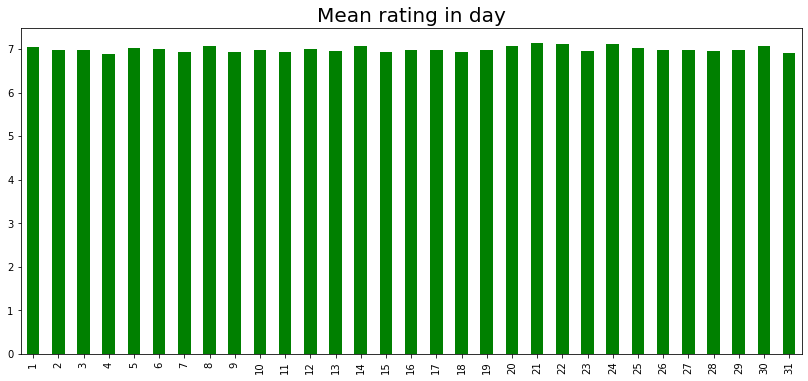

In [29]:

df_all['day'] = df_all['date'].dt.day
rating = df_all.groupby('day')['rating'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean rating in day", fontsize = 20)

We checked whether the day of the week affects the rating like salary day, but it does not make a big difference.

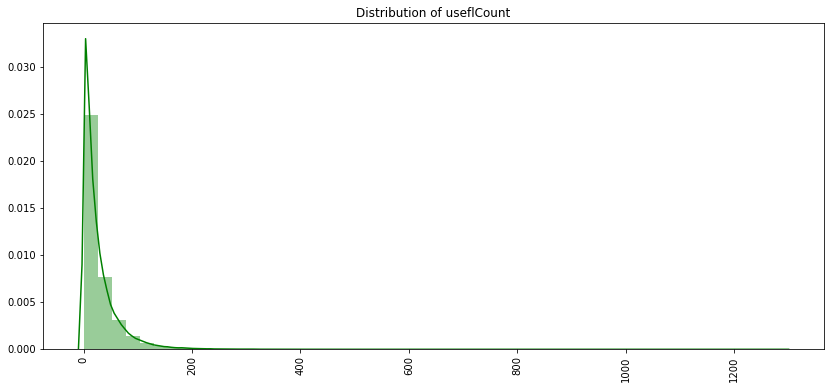

In [30]:
plt.figure(figsize=(14,6))
sns.distplot(df_all["useflCount"].dropna(),color="green")
plt.xticks(rotation='vertical')
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("Distribution of useflCount")
plt.show()

In [31]:
df_all["useflCount"].describe()

count    215063.000000
mean         28.001004
std          36.346069
min           0.000000
25%           6.000000
50%          16.000000
75%          36.000000
max        1291.000000
Name: useflCount, dtype: float64

If you look at the distribution of usefulCount, you can see that the difference between minimum and maximum is 1291, which is high. In addition, the deviation is huge, which is 36. The reason for this is that the more drugs people look for, the more people read the review no matter their contents are good or bad, which makes the usefulcount very high. So when we create the model, we will normalize it by conditions, considering people's accessibility.


Text(0.5, 1.0, 'Total Missing Value ')

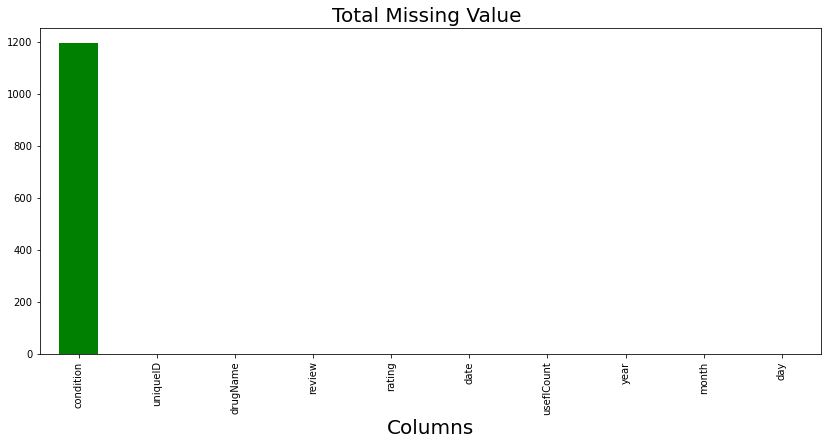

In [32]:
percent = (df_all.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (14,6), fontsize = 10, color='green')
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value ", fontsize = 20)

In [33]:
print("Missing value (%):", 1200/df_all.shape[0] *100)

Missing value (%): 0.5579760349292998


#We will delete because the percentage is lower than 1%.



In [34]:
df_train = df_train.dropna(axis=0)
df_test = df_test.dropna(axis=0)

Text(0.5, 1.0, 'Total Missing Value ')

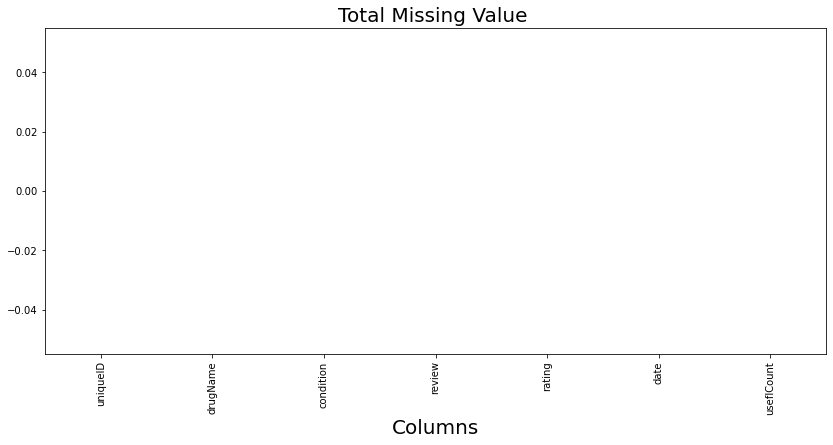

In [35]:
df_all = pd.concat([df_train,df_test]).reset_index()
del df_all['index']
percent = (df_all.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (14,6), fontsize = 10, color='green')
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value ", fontsize = 20)

In [36]:
all_list = set(df_all.index)
span_list = []
for i,j in enumerate(df_all['condition']):
    if '</span>' in j:
        span_list.append(i)
new_idx = all_list.difference(set(span_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']


In [37]:
#Next, we will delete conditions with only one drug.
df_condition = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(20)

,condition,drugName
816,Short Stature for Age,1
817,"Meningitis, Meningococcal",1
818,Angioedema,1
819,Nausea (phosphorated carbohydrate solution),1
820,Myotonia Congenita,1
821,Sleep Paralysis,1
822,Muscle Twitching,1
823,Cluster-Tic Syndrome,1
824,Mumps Prophylaxis,1
825,Cogan's Syndrome,1


In [38]:
df_condition_1 = df_condition[df_condition['drugName']==1].reset_index()
df_condition_1['condition'][0:10]

0              Wound Cleansing
1            Aggressive Behavi
2     Yellow Fever Prophylaxis
3         Tuberculosis, Active
4           Hyperbilirubinemia
5                Hydrocephalus
6                Hypercalcemia
7         Gestational Diabetes
8            Ectopic Pregnancy
9    unctional Gastric Disorde
Name: condition, dtype: object

In [39]:
all_list = set(df_all.index)
condition_list = []
for i,j in enumerate(df_all['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)
            
new_idx = all_list.difference(set(condition_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']

In [40]:
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [4]:
 pip install stop-words


  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32916 sha256=06ce15720332706907f898aa85c85115e474686d15d0adbd657f0d8922e0b771
  Stored in directory: c:\users\ihebb\appdata\local\pip\cache\wheels\eb\03\0d\3bd31c983789aeb0b4d5e2ca48590288d9db1586cf5f225062
Successfully built stop-words
Note: you may need to restart the kernel to use updated packages.


In [41]:
stops = set(stopwords.words('english'))


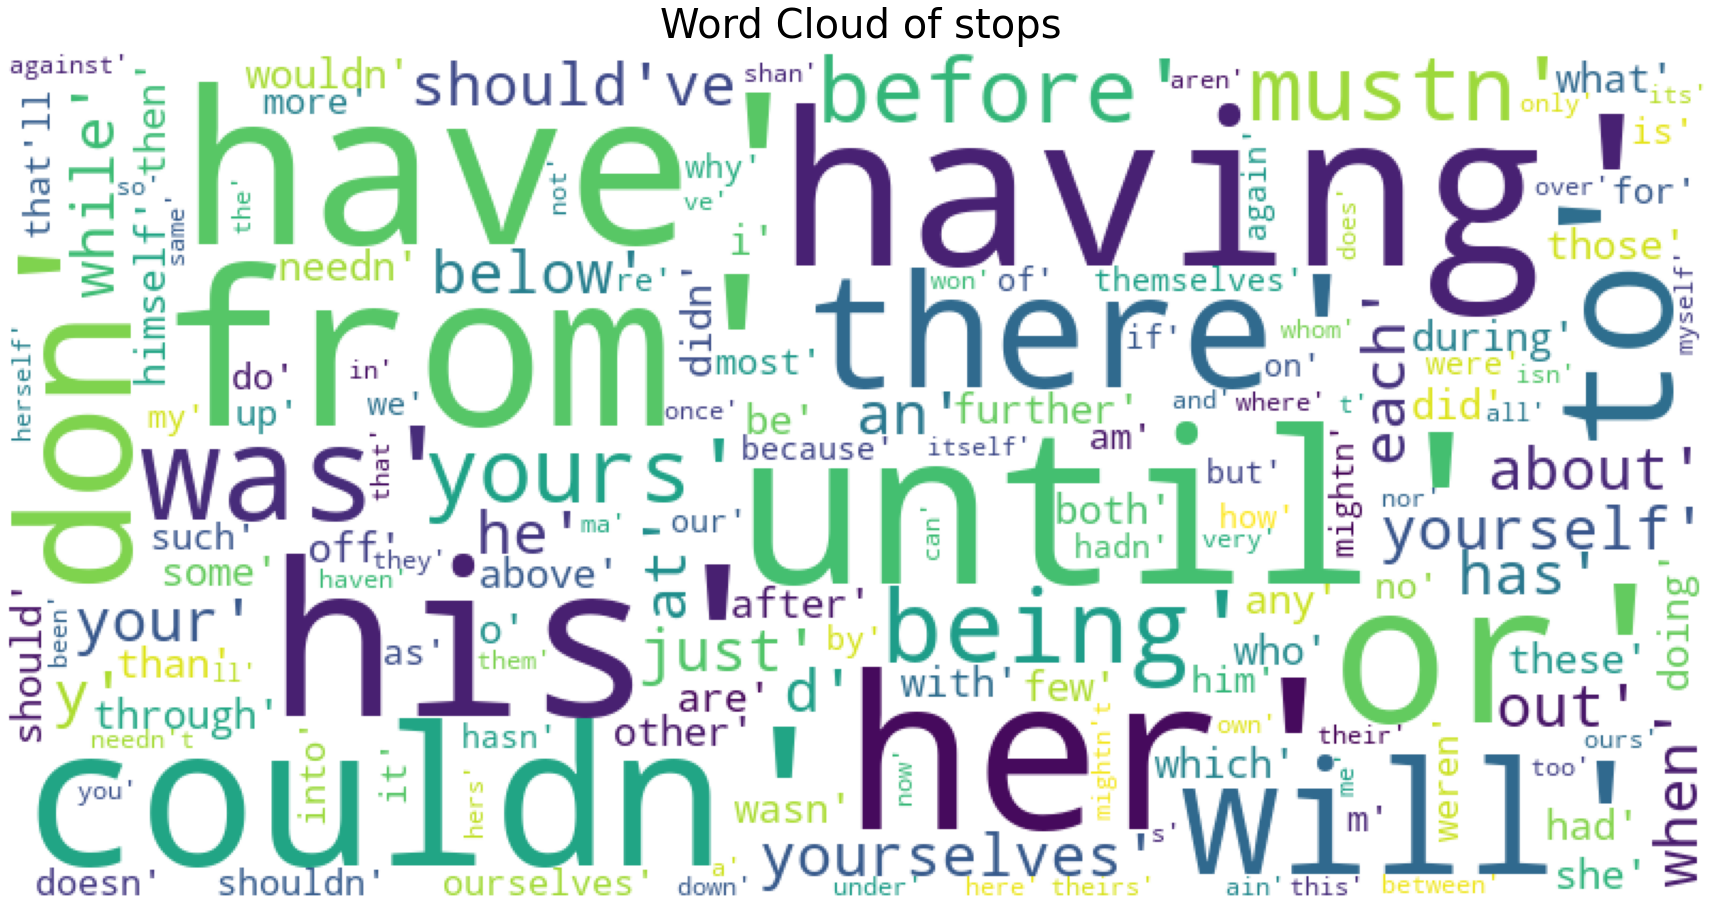

In [42]:
#https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc kernel 
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(stops, title="Word Cloud of stops")


In [43]:
not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [54]:
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [53]:
pip install keras 

Note: you may need to restart the kernel to use updated packages.


In [52]:
pip install tensorflow

  Using cached tensorflow-2.5.0-cp38-cp38-win_amd64.whl (422.6 MB)
  Using cached h5py-3.1.0-cp38-cp38-win_amd64.whl (2.7 MB)
  Using cached tensorboard-2.5.0-py3-none-any.whl (6.0 MB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached grpcio-1.34.1-cp38-cp38-win_amd64.whl (2.9 MB)
  Using cached tensorflow_estimator-2.5.0-py2.py3-none-any.whl (462 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached absl_py-0.13.0-py3-none-any.whl (132 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached keras_nightly-2.5.0.dev2021032900-py2.py3-none-any.whl (1.2 MB)
  Using cached Markdown-3.3.4-py3-none-any.whl (97 kB)
  Using cached google_auth_oauthlib-0.4.4-py2.py3-none-any.whl (18 kB)

  Attemptin

In [55]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(stemming_words))


In [56]:
%time df_all['review_clean'] = df_all['review'].apply(review_to_words)


Wall time: 6min 34s


In [57]:
# Make a rating
df_all['sentiment'] = df_all["rating"].apply(lambda x: 1 if x > 5 else 0)

In [58]:
df_train, df_test = train_test_split(df_all, test_size=0.33, random_state=42) 

In [59]:
# https://github.com/corazzon/KaggleStruggle/blob/master/word2vec-nlp-tutorial/tutorial-part-1.ipynb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2, # 토큰이 나타날 최소 문서 개수
                             ngram_range=(4, 4),
                             max_features = 20000
                            )
vectorizer

CountVectorizer(max_features=20000, min_df=2, ngram_range=(4, 4))

In [60]:
#https://stackoverflow.com/questions/28160335/plot-a-document-tfidf-2d-graph
pipeline = Pipeline([
    ('vect', vectorizer),
])

In [61]:
%time train_data_features = pipeline.fit_transform(df_train['review_clean'])
%time test_data_features = pipeline.fit_transform(df_test['review_clean'])


Wall time: 45.7 s
Wall time: 23.9 s


In [62]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Bidirectional, LSTM, BatchNormalization, Dropout
from tensorflow.python.keras.preprocessing.sequence import pad_sequences


In [63]:
#Source code in keras 김태영'blog
# 0. Package
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
import random

# 1. Dataset
y_train = df_train['sentiment']
y_test = df_test['sentiment']
solution = y_test.copy()

# 2. Model Structure
model = keras.models.Sequential()

model.add(keras.layers.Dense(200, input_shape=(20000,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(300))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# 3. Model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [64]:
 model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               4000200   
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
activation (Activation)      (None, 200)               0         
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               60300     
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
activation_1 (Activation)    (None, 300)               0

NameError: name 'hist' is not defined

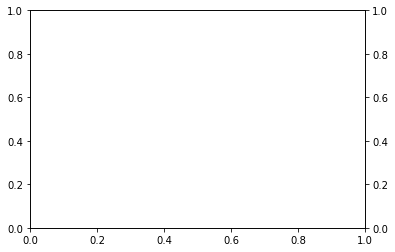

In [69]:
# 5. Traing process
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['acc'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. Evaluation
loss_and_metrics = model.evaluate(test_data_features, y_test, batch_size=32)
print('loss_and_metrics : ' + str(loss_and_metrics))

In [70]:
sub_preds_deep = model.predict(test_data_features,batch_size=32)


InvalidArgumentError: indices[3] = [3,16382] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SerializeManySparse]

## Summary

Our team set the topic as recommending the right medicine for the patient's condition with reviews and proceeded the project according to the topic with the data exploration, data preprocessing and modeling. In the data exploration section, we looked at the forms of data using visualization techniques and statistical techniques. We also looked for n-grams that can best represent emotions, and the relationship with date and rating. The next step was to preprocess the data according to the topic we set, such as removing the condition that has only one drug for recommendation. In the process of modeling, we used deep learning model with n-gram, and additionally used a machine learning model called Lightgbm to overcome the limitation of natural language processing. In addition, we conducted emotional analysis using emotional word dictionary to overcome limitations of package formed with movie data. In addition, we nomalized usefulcount by condition for better reliability. These steps allowed us to calculate the final predicted value and recommend the appropriate drug for each condition according to the order of the value.